In [1]:
import gym
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import CheckpointCallback
import torch
import dubins
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.cm as cm
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython import display
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm  

writer = SummaryWriter('logs/')  # 初始化TensorBoard


In [2]:
class Drone:
    def __init__(self, x=0, y=0, theta=45, Destroy=0, drone_id=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.id = drone_id
        

        ##规划问题留给
        # self.Tg = T_tg  # 决定goal的坐标
        # self.Tc = T_tc  # 决定规划的角度
        self.Destroy = Destroy
        self.velocity = 0.35
        self.num_missle = 2
        self.omega = 0 ##角速度
        self.max_omega = 10
        self.path = []
        self.name =drone_id
        # 感知信息
        self.friends = {}  # 使用字典存储队友信息
        self.enemies = []  # 敌方的信息
        self.fire_path=[]

        # # 决策信息
        # self.X = np.array(enemy_drone)  # 敌人攻击决策
        # self.Y = np.zeros((num_enemies, num_tactics))  # 战术选择

    def move(self, time_step):
        if self.Destroy == 0: 
            self.path.append((self.x,self.y))
            self.x += self.velocity * np.cos(np.radians(self.theta)) * time_step
            self.y += self.velocity * np.sin(np.radians(self.theta)) * time_step
            self.theta = (self.theta + self.omega * time_step) % 360

    def fire_missile(self, target):
        """发射导弹并影响目标飞机的状态"""
        reward = 0  # 初始化奖励
        if self.num_missle > 0:
            if target.Destroy == 0:  # 如果目标存活
                # print(f"{self.name}: 正在发射导弹...")
                self.num_missle -= 1  # 发射导弹后，A飞机导弹数量减少
                reward +=target.receive_attack(self)  # 目标被击落，状态更新为0 如果敌方发射，我方受损，敌方加分
                self.fire_path.append([(self.x,self.y),(target.x,target.y)])
                # reward += 5  # 发射导弹奖励
                # print(f"{self.name}: 导弹发射成功，剩余导弹数量: {self.num_missle}")
                # print(f"{target.name}: 状态更新为0，已被击落。\n")
            else:
                pass# print(f"{self.name}: 目标{target.name}已被击落，无法再发射导弹。\n")
        else:
            pass
            # print(f"{self.name}: 导弹已用尽，无法发射。\n")
        return reward

    def receive_attack(self, attacker):
        """根据攻击者与目标飞机的距离决定攻击是否成功"""
        reward = 0  # 初始化惩罚
        # 计算两架飞机之间的距离
        distance = self.calculate_distance(attacker)
        
        # 根据距离计算成功率（距离越近成功率越高）
        success_rate = self.calculate_success_rate(distance)
        # print(f"{self.name}: 距离 {distance:.2f}，成功率为 {success_rate}%")
        
        # 随机生成一个0到100之间的数，判断是否成功
        if random.randint(0, 100) <= success_rate:
            self.Destroy = 1  # 被击落
            reward -= 5  # 被击中惩罚
            # print(f"{self.name}: 被攻击击落！\n")
        else:
            pass
            # print(f"{self.name}: 攻击未命中，继续存活。\n")
        
        return reward 

    def calculate_distance(self, attacker):
        """计算两架飞机之间的欧几里得距离"""
        return math.sqrt((self.x - attacker.x)**2 + (self.y - attacker.y)**2)

    def calculate_success_rate(self, distance):
        """根据距离计算攻击成功率"""
        # 映射距离与成功率，距离10时成功率50%，距离3时成功率80%
        if distance >= 10:
            return 50
        elif distance <= 3:
            return 80
        else:
            # 距离范围在[3, 10]之间，根据比例计算成功率
            return 50 + (80 - 50) * (10 - distance) / 7        
        

###有效的目标和战术都是1、2、3

class Myplane(Drone):
    def __init__(self, x=0, y=0, theta=45, Destroy=0, drone_id=None, T_tg=0, T_tc=0, num_tactics=3):
        super().__init__(x, y, theta, Destroy,  drone_id)
        self.T_tg = T_tg
        self.T_tc = T_tc
        self.num_tactics = num_tactics
        self.dubins_path = []
        self.last_args = None
        self.desired_theta =0
        self.angle_error = 0

        self.dubins_lable = 0


        self.Kp = 1.0  # 比例增益
        self.Ki = 0.1  # 积分增益
        self.Kd = 0.05  # 微分增益

        self.previous_error = 0  # 上一次的误差
        self.integral = 0  # 积分部分
        
    def lock_plane(self,planes):
        reward = 0
        for plane in planes:
            dx = plane.x - self.x
            dy = plane.y - self.y            
            distance = math.sqrt(dx**2 + dy**2)
            target_angle = math.degrees(math.atan2(dy, dx))

            target_angle = (target_angle + 360) % 360
            drone_angle = (self.theta + 360) % 360
            
            # 计算角度差
            angle_diff = abs(target_angle - drone_angle)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            # 检查目标是否在角度和距离范围内
            if angle_diff <= 45 and distance <= 10:
                self.fire_missile(plane)
                reward += self.fire_missile(plane)  # 发射导弹后奖励

        return reward

   

    def plan_road(self,T_tg,T_tc,enemy_planes):
        ##先不判断是否到达某个距离才规划
        self.enemy_postion=[enemy_planes[T_tg-1].x,enemy_planes[T_tg-1].y]
        # print(f'敌方战机位置{self.enemy_postion}')
        if (T_tg,T_tc) == self.last_args:
            # print("战术策略与上次相同，不更新路径")
            return
        if T_tg !=0 and T_tc !=0:
            self.last_args =(T_tg,T_tc)
            if T_tc == 1:
                goal_postion_x = enemy_planes[T_tg-1].x -80
                goal_postion_y = enemy_planes[T_tg-1].y -80
                goal_theta     = enemy_planes[T_tg-1].theta
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            ##右突击
            if T_tc == 2:
                goal_postion_x = enemy_planes[T_tg-1].x - 70
                goal_postion_y = enemy_planes[T_tg-1].y - 70
                goal_theta     = enemy_planes[T_tg-1].theta +90
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            ###左突击
            if T_tc == 3:
                goal_postion_x = enemy_planes[T_tg-1].x - 60
                goal_postion_y = enemy_planes[T_tg-1].y - 70
                goal_theta     = enemy_planes[T_tg-1].theta - 90
                goal_postion   = (goal_postion_x,goal_postion_y,np.deg2rad(goal_theta))
                self_postion   = (self.x,self.y,np.deg2rad(self.theta))

            
            turning_radius = 10 ###这个圆和 飞机的角速度很有关系，角速度很小，小弯转不了

            # 生成最短路径
            path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
            
            # 采样路径上的点
            configurations, _ = path.sample_many(0.3)  # 采样间隔为0.1
            
            # 提取 x, y 坐标
            x_coords = [config[0] for config in configurations]
            y_coords = [config[1] for config in configurations]
            self.dubins_path = configurations

    def plan_road2(self,T_tg,T_tc,enemy_planes):
        enemy_plane=enemy_planes[T_tg-1]
        self.enemy_postion=[enemy_planes[T_tg-1].x,enemy_planes[T_tg-1].y]
        turning_radius = 10 ###这个圆和 飞机的角速度很有关系，角速度很小，小弯转不了
        distance1 = math.sqrt((self.x - self.enemy_postion[0])**2 + (self.y - self.enemy_postion[1])**2)
        turning_radius = max(distance1/150 * turning_radius,3)
        # print(f'敌方战机位置{self.enemy_postion}')
        if (T_tg,T_tc) == self.last_args:
            # print("战术策略与上次相同，不更新路径")
            return
        if T_tg !=0 and T_tc !=0:
            self.last_args =(T_tg,T_tc)
            if T_tc == 1:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                A_point[0] = enemy_plane.velocity * np.cos(np.radians(enemy_plane.theta)) * 1000
                A_point[1] = enemy_plane.velocity * np.sin(np.radians(enemy_plane.theta)) * 1000
        
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)
                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path


            if T_tc == 2:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta +90

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)
                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path

            if T_tc ==3:
                # goal_postion_x = enemy_planes[T_tg-1].x -80
                # goal_postion_y = enemy_planes[T_tg-1].y -80
                B_point =self.enemy_postion
                A_point =[0,0]
                sampling_points = np.linspace(A_point, B_point, num=20)
                goal_theta     = enemy_planes[T_tg-1].theta -90

                selected_point = []
                dubins_path = []
                diff_length = 1000
                for point in sampling_points:
                    goal_postion   = (point[0],point[1],np.deg2rad(goal_theta))##暂时就以这个作为向后攻击的坐标
                    self_postion   = (self.x,self.y,np.deg2rad(self.theta))
                    path = dubins.shortest_path(self_postion, goal_postion, turning_radius)
                    path_len=path.path_length()
                    path_len2=distance.euclidean((point[0],point[1]),(B_point[0],B_point[1]))
                    abs_diff = abs(path_len -path_len2)

                    if abs_diff <diff_length:
                        selected_point = point
                        diff_length = abs_diff
                        dubins_path , _= path.sample_many(0.3)
                self.dubins_path =dubins_path

    
    def move_along_omega(self):
        if not self.dubins_path:
            return

        if self.dubins_lable <= len(self.dubins_path)-1:
            target_x, target_y, target_theta = self.dubins_path[self.dubins_lable]


        while self.dubins_lable < len(self.dubins_path):
            self.desired_theta = np.degrees(np.arctan2(target_y - self.y, target_x - self.x))
            self.angle_error = (self.desired_theta - self.theta + 180) % 360 - 180
            
            distance = math.sqrt((self.x - target_x)**2 + (self.y - target_y)**2)
            if distance < 0.5:  # 当距离小于0.5时更新路径标签，抛弃过近的引导点
                self.dubins_lable += 1
                # print(f"plane{self.name}:dubins_lable{self.dubins_lable}---{len(self.dubins_path)}")
                if self.dubins_lable >= len(self.dubins_path): ###引导点终止在最后一个点
                    self.dubins_lable = len(self.dubins_path) - 1
                    # print('完成规划路线-------------------------------------------')
                    return
                target_x, target_y, target_theta = self.dubins_path[self.dubins_lable]
            else:
                break
        if self.dubins_lable >= len(self.dubins_path)-1:

            target_x,target_y=self.enemy_postion
            
        distance = math.sqrt((self.x - target_x)**2 + (self.y - target_y)**2)

            
        self.desired_theta = np.degrees(np.arctan2(target_y - self.y, target_x - self.x))
        self.angle_error = (self.desired_theta - self.theta + 180) % 360 - 180  # 角度差，限制在[-180, 180]
        self.integral += self.angle_error  # 积分
        derivative = self.angle_error - self.previous_error  # 微分（误差变化速率）
        
        # self.omega +=  self.angle_error * 0.01  # 控制增益可以调整
        omega_control = self.Kp * self.angle_error + self.Ki * self.integral + self.Kd * derivative
        
        # 更新角速度（omega）
        self.omega = omega_control
        # self.omega=self.angle_error * 0.05
        self.omega = max(min(self.omega, self.max_omega), -self.max_omega)  # 限制最大角速度
        # self.dubins_path.pop(0)

        self.previous_error = self.angle_error

        # if self.dubins_lable == len(self.dubins_path)-1:
        #     self.omega = 0
class Enemy_plane(Drone):
    def __init__(self, x=100, y=100, theta=135, Destroy=0, drone_id=None):
        super().__init__(x, y, theta, Destroy, drone_id)
    #     self.attack_history = {}

    # def record_attack(self, attacker, tactic):
    #     """记录攻击者使用的战术"""
    #     if attacker.name not in self.attack_history:
    #         self.attack_history[attacker.name] = []
    #     self.attack_history[attacker_id].append(tactic)
    ##发现锁定目标，开火
    def lock_plane(self,planes):
        reward =0
        for plane in planes:
            dx = plane.x - self.x
            dy = plane.y - self.y            
            distance = math.sqrt(dx**2 + dy**2)
            target_angle = math.degrees(math.atan2(dy, dx))

            target_angle = (target_angle + 360) % 360
            drone_angle = (self.theta + 360) % 360
            
            # 计算角度差
            angle_diff = abs(target_angle - drone_angle)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            # 检查目标是否在角度和距离范围内
            if angle_diff <= 45 and distance <= 10:
                reward +=self.fire_missile(plane)

        return reward


            


In [13]:

class AirFightEnv(gym.Env):
    def __init__(self):
        super().__init__()  # Python 3 推荐写法
        ###观测空间暂时不写
        self.num_Fplanes = 3
        ##列表化无人机装备
        # self.friendly_drones = Myplane(x=0, y=0, theta=45, drone_id=1)
        self.friendly_drones =[Myplane(x=i*10,y=i*10,theta=45,drone_id=i) for i in range(self.num_Fplanes) ]
        # self.enemy_drones = Enemy_plane(x=80, y=80, theta=225, drone_id=2)
        self.enemy_drones =[Enemy_plane(x=100,y=100,theta=225,drone_id ='A'),Enemy_plane(x=90,y=100,theta=225,drone_id ='B'),Enemy_plane(x=100,y=90,theta=225,drone_id ='C')]
        
        
        #暂时都是一架
        self.friendly_drone = self.friendly_drones[0]
        self.enemy_drone =self.enemy_drones[0]
        
        self.time_step = 1  # 每次step为1秒
        # 初始化状态
        self.state = None
        self.last_action = None
        self.mylast_Destroy = [0 for i in range(len(self.friendly_drones))]
        self.enemy_last_Destroy = [0 for i in range(len(self.enemy_drones))]
        self.reset()
        
    def reset(self):
                # 重置环境状态
        self.friendly_drones =[Myplane(x=i*10,y=i*10,theta=45,drone_id=i) for i in range(self.num_Fplanes) ]
        self.enemy_drones =[Enemy_plane(x=100,y=100,theta=225,drone_id ='A'),Enemy_plane(x=90,y=100,theta=225,drone_id ='B'),Enemy_plane(x=100,y=90,theta=225,drone_id ='C')]
        self.enemy_drone =self.enemy_drones[0]
        self.mylast_Destroy = [0 for i in range(len(self.friendly_drones))]
        self.enemy_last_Destroy = [0 for i in range(len(self.enemy_drones))]

        state = []
        # 初始化状态向量
        for drone in self.friendly_drones:
                o_drone = []

                for other_drone in self.friendly_drones:
                    if other_drone != drone:
                        o_drone.append(np.array([other_drone.x-drone.x, other_drone.y-drone.y, other_drone.theta-drone.theta, other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                    else:
                        o_drone.append(np.array([0,0,0,other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                for enemy_drone in self.enemy_drones:
                    o_drone.append(np.array([enemy_drone.x-drone.x, enemy_drone.y-drone.y, enemy_drone.theta-drone.theta,enemy_drone.Destroy]))
                state.append(o_drone)
        
        # 将状态转化为 numpy 数组
        self.state = np.array(state,dtype=object)
        self.last_action = None

        
        
        return self.state

    def step(self,action):
        self.action = action
        reward = 0
        reward -=1

        ##奖励9 多方向攻击
        counts = count_unique_second_elements(action)
        conditional_sum = sum(value for value in counts.values() if value > 1)
        reward += conditional_sum
        ##1切换目标惩罚
        if self.last_action != action:
            if self.last_action != None:
                
                for action_i in action:
                    if action_i[0] != self.last_action[0]:
                        reward -=3
                    else:
                        if action_i[1] != self.last_action[1]:
                            reward -=1
         ##惩罚4   同一敌机同一方向             
        for i in range(len(action)):
            action_i = action[i]
            for j in range(i+1,len(action)):
                if action_i == action[j]:
                    reward -=1
        ##5遗漏目标惩罚      
        target_list = []     
        for action_i in action:
            
            target_number = action_i[0]
            target_list.append(target_number)
        unique_target = set(target_list)
        miss_pen=len(self.enemy_drones)-len(unique_target) 
        reward -=miss_pen

        ##如果这个时刻被摧毁



        tatic_list = []
        #输入我方无人机的目标和战术
        goal_number = 1
        enemy_drone1= self.enemy_drone
        # print('敌方战机单个',enemy_drone1.x,enemy_drone1.y)
        # mydrone = self.friendly_drones[0]
        i=0
        for plane in self.friendly_drones:
            plane.T_tc =action[i][1]
            plane.T_tg = action[i][0]
            
            
            plane.plan_road2(action[i][0],action[i][1],self.enemy_drones)
            plane.move_along_omega()
            plane.move(self.time_step)
            reward+= plane.lock_plane(self.enemy_drones)
            
            i+=1

     
        for enemy_drone in self.enemy_drones:
            enemy_drone.move(self.time_step)
            reward -= enemy_drone.lock_plane(self.friendly_drones)
        state = []

        ##观测空间  

        for drone in self.friendly_drones:
            o_drone = []

            for other_drone in self.friendly_drones:
                if other_drone != drone:
                    o_drone.append(np.array([other_drone.x-drone.x, other_drone.y-drone.y, other_drone.theta-drone.theta, other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
                else:
                    o_drone.append(np.array([0,0,0,other_drone.T_tg,other_drone.T_tc,other_drone.Destroy]))
            for enemy_drone in self.enemy_drones:
                o_drone.append(np.array([enemy_drone.x-drone.x, enemy_drone.y-drone.y, enemy_drone.theta-drone.theta,enemy_drone.Destroy]))
            state.append(o_drone)
            
        ##存活惩罚6、7
        # # 记录存活状况
        friendly_destroy = [drone.Destroy for drone in self.friendly_drones]
        enemy_destroy = [drone.Destroy for drone in self.enemy_drones]
        friendly_destroy_pen = sum(np.array(friendly_destroy)-np.array(self.mylast_Destroy))
        enemy_destroy_reward = sum(np.array(enemy_destroy)-np.array(self.enemy_last_Destroy))
        reward -= friendly_destroy_pen
        reward += enemy_destroy_reward



        
        # 将状态转化为 numpy 数组
        self.state = np.array(state,dtype=object)
        done = self.check_done()
            
        ###变换战术目标和战术惩罚
        self.last_action = action
        self.mylast_Destroy = friendly_destroy
        self.enemy_last_Destroy = enemy_destroy

        return self.state,reward,done,{'enemy_destroy_info':[done.Destroy*(-1)*10e+8 for done in self.enemy_drones],'enemy_drone_info':[enemy_drone for enemy_drone in self.enemy_drones]}
    def check_done(self):
        if all(drone.Destroy == 1 for drone in self.enemy_drones) or all(drone.Destroy == 1 for drone in self.friendly_drones):
            return True
        else:
            return False
    def render(self, mode='human'):
        plt.figure(figsize=(10, 10))
        target_list = [action_i[0] for action_i in self.action]
        colors = ['green', 'black', 'yellow']

        for i, target_i in enumerate(target_list):
            plt.scatter(self.enemy_drones[target_i-1].x +random.randint(0, 3), self.enemy_drones[target_i-1].y +random.randint(0, 3), 
                        color=colors[i], marker='^', s=50, label=f"Enemy Drone {self.enemy_drones[target_i-1].id}")

        for drone in self.friendly_drones:
            friendly_x, friendly_y = zip(*drone.path) if drone.path else ([], [])
            plt.plot(friendly_x, friendly_y, 'b-', label=f"Friendly Path{drone.name}")
            dubins_lable =drone.dubins_lable
            plt.scatter(drone.dubins_path[dubins_lable][0], drone.dubins_path[dubins_lable][1], color='blue', marker='^', s=100, label="Friendly Drone (point)")
    
    
            # 绘制规划路径
            if hasattr(drone, 'dubins_path') and drone.dubins_path:
                dubins_x = [point[0] for point in drone.dubins_path]
                dubins_y = [point[1] for point in drone.dubins_path]
                plt.plot(dubins_x, dubins_y, linestyle='--', label=f"Dubins Path{drone.id}")
        
            # 绘制当前己方无人机的位置和方向
            if drone:
                # print('我方坐标',drone.x, drone.y)
                # print('dubins',drone.dubins_path[0])
                # print(f'angle_info,期望角度{drone.desired_theta},实际角度{drone.theta},误差角度{drone.angle_error}，角速度{drone.omega}')
                if drone.Destroy == 0:
                    plt.quiver(
                        drone.x, drone.y,
                        np.cos(np.radians(drone.theta)), np.sin(np.radians(drone.theta)),
                        color='blue', scale=10, label="Friendly Drone"
                    )   
                else:
                    plt.scatter(drone.x, drone.y, color='blue', marker='x', s=100, label=f"Friendly Drone{drone.id}")   
            if drone.fire_path:
                x_coords, y_coords = zip(*drone.fire_path)
                plt.plot(x_coords, y_coords,  marker='x', linestyle='-', color='pink', label='Fire Path——my')



        
        # 绘制敌方无人机的路径
        for enemy_drone in self.enemy_drones:
            enemy_x, enemy_y = zip(*enemy_drone.path) if enemy_drone.path else ([], [])
            plt.plot(enemy_x, enemy_y, 'r-', label=f"Enemy Path{enemy_drone.id}")
        # 绘制当前敌方无人机的位置和方向
            if enemy_drone:
                if enemy_drone.Destroy == 0:    
                    plt.quiver(
                        enemy_drone.x, enemy_drone.y,
                        np.cos(np.radians(enemy_drone.theta)), np.sin(np.radians(enemy_drone.theta)),
                        color='red', scale=10, label=f"Enemy Drone{enemy_drone.id}"
                    )
                else:
                    plt.scatter(enemy_drone.x, enemy_drone.y, color='red', marker='x', s=100, label=f"Enemy Drone{enemy_drone.id}")
                if enemy_drone.fire_path:
                    x_coords, y_coords = zip(*enemy_drone.fire_path)
                    plt.plot(x_coords, y_coords, marker='o', linestyle='-',color='k', label=f'Fire Path——enemy{enemy_drone.id}')
                    print(enemy_drone.fire_path)
        
        
        # 设置图形属性
        plt.xlim(-10, 100)
        plt.ylim(-10, 100)
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Drone Path and Direction")
        plt.legend()
        plt.grid(True)
        
        # 显示图像
        if mode == 'human':
            display.clear_output(wait=True)  # 清除之前的输出
            display.display(plt.gcf())      # 显示当前图像
            plt.close()                     # 关闭图像以避免重复显示
        elif mode == 'rgb_array':
            plt.draw()
            plt.pause(0.01)
            return plt.gcf()

    def calculate_reward(self):
        pass
    


In [12]:
def count_unique_second_elements(two_d_list):
    """
    统计二维列表中，每个第一个元素对应的第二个元素不同的种类数。

    :param two_d_list: List of lists，每个子列表包含至少两个元素
    :return: 字典，键为第一个元素，值为第二个元素的不同种类数
    """
    # 使用 defaultdict 来自动处理不存在的键
    groups = defaultdict(set)
    
    for sublist in two_d_list:
        if len(sublist) < 2:
            continue  # 跳过不符合条件的子列表
        first_elem = sublist[0]
        second_elem = sublist[1]
        groups[first_elem].add(second_elem)
    
    # 计算每个组的种类数
    result = {key: len(value) for key, value in groups.items()}
    
    return result
# 分离离散数据和连续数据
def separate_data(state):
    discrete_data = []
    continuous_data = []
    
    
    for row in state:
        discrete_row = []
        continuous_row = []
        for element in row:
            element = np.array(element)  # 确保元素是 NumPy 数组
            if len(element) == 6:
                discrete_row.append(element[3:].astype(object))  # 后3个是离散数据
                continuous_row.append(element[:3].astype(float))  # 前3个是连续数据
            elif len(element) == 4:
                discrete_row.append(element[3:].astype(object))  # 最后1个是离散数据
                continuous_row.append(element[:3].astype(float))  # 前3个是连续数据
        discrete_data.append(np.array(discrete_row, dtype=object))
        continuous_data.append(np.array(continuous_row, dtype=float))
    
    return np.array(discrete_data, dtype=object), np.array(continuous_data, dtype=float)

# 滑动标准化函数
def sliding_normalization(new_data, mean, variance, n):
    new_mean = mean + (new_data - mean) / (n + 1)
    new_variance = variance + (new_data - mean) * (new_data - new_mean)
    normalized_data = (new_data - new_mean) / np.sqrt(new_variance + 1e-8)  # 使用 np.sqrt
    return normalized_data, new_mean, new_variance

# 合并离散数据和标准化后的连续数据
def merge_data(discrete_data, normalized_continuous_data):
    processed_state = []
    for i in range(discrete_data.shape[0]):
        row = []
        for j in range(discrete_data.shape[1]):
            if len(discrete_data[i][j]) == 3:  # 原始长度为6的元素
                merged = np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]])
                row.append(merged.astype(object))
            elif len(discrete_data[i][j]) == 1:  # 原始长度为4的元素
                merged = np.concatenate([normalized_continuous_data[i][j], discrete_data[i][j]])
                row.append(merged.astype(object))
        processed_state.append(np.array(row, dtype=object))
    return np.array(processed_state, dtype=object)
def process_vector1(vec):
    if len(vec) == 4:
        # 前3个元素 + 两个0 + 原第4个元素
        return np.array([vec[0], vec[1], vec[2], 0, 0, vec[3]], dtype=vec.dtype)
    else:
        return vec  # 长度6的向量保持不变
def process_vector(original_data):
    processed_data=[]
    for row in original_data:
        new_row = []
        for element in row:
            new_element = process_vector1(element)
            new_row.append(new_element)
        processed_data.append(new_row)
    return processed_data


def sliding_normalization(new_data, mean, variance, n):
    new_mean = mean + (new_data - mean) / (n + 1)
    new_variance = variance + (new_data - mean) * (new_data - new_mean)
    normalized_data = (new_data - new_mean) / np.sqrt(new_variance + 1e-8)  # 使用 np.sqrt
    return normalized_data, new_mean, new_variance
def process_continue_data(state,mean,variance,n):
    discrete_data, continuous_data = separate_data(state)
    normalized_continuous_data = np.zeros_like(continuous_data, dtype=float)

    for i in range(continuous_data.shape[0]):
        for j in range(continuous_data.shape[1]):
            normalized_continuous_data[i][j], mean[j], variance[j] = sliding_normalization(
                continuous_data[i][j], mean[j], variance[j], n
            )
    processed_state = merge_data(discrete_data, normalized_continuous_data)
    processed_state=process_vector(processed_state)
    return processed_state,mean,variance


def Net2data(processed_state,state): ##返回np
    new_oij_state=[]
    for(i,o_i) in enumerate(processed_state):
        for j in range(3):
            oij = state[i][3+j] ##敌机状态state3*6*6
            # print(oij.shape,'oij.shape')
            oij = np.pad(oij, (0, 2), mode='constant', constant_values=0)  # 填充 0    
            # print(oij.shape,'oij.shape_padding')
            # print(np.array(o_i).shape,'o_i.shape')
            cat_state=np.concatenate((o_i,[oij]),axis=0)###增加一个敌机观测o_i 6*6 
            new_oij_state.append(cat_state)
    new_oij_state_np = np.array(new_oij_state, dtype=np.float32)    
    return new_oij_state_np

In [5]:
class Normalization:
    def __init__(self):
        env = AirFightEnv()
        state = env.reset()
        discrete_data, continuous_data = separate_data(state)

        self.mean = np.zeros_like(continuous_data[0], dtype=float)
        self.variance = np.ones_like(continuous_data[0], dtype=float)
        self.n=0
    def process_continue_data(self,state):
        return process_continue_data(state,self.mean,self.variance,n)


class TargetNetwork(nn.Module):
    def __init__(self):
        super(TargetNetwork, self).__init__()
        self.fc1 = nn.Linear(36, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        # x形状: (batch_size, 3, 36)
        batch_size = x.shape[0]
        
        # 处理musk_info（保持原始逻辑，但适配batch）
        p1_reshaped = x.view(batch_size, 3, 6, 6)  # (B,3,6,6)
        musk_info = p1_reshaped[:, 0, -3:, -1] * 10e8 * (-1)  # (B,3)
        
        # 全连接处理
        x = x.view(batch_size*3, 36)  # (B*3,36)
        x = torch.relu(self.fc1(x))    # (B*3,64)
        x = self.fc2(x)                # (B*3,3)
        x = x.view(batch_size, 3, 3)   # (B,3,3)
        
        # 添加musk_info（适配batch）
        x += musk_info.unsqueeze(-1)   # (B,3,3) + (B,3,1)
        return F.softmax(x, dim=-1)    # (B,3,3)

class TaticNetwork(nn.Module):
    def __init__(self):
        super(TaticNetwork, self).__init__()
        self.fc1 = nn.Linear(42, 64)
        self.fc2 = nn.Linear(64, 6)
        self.fc3 = nn.Linear(3, 6)
        self.fc4 = nn.Linear(9, 3)

    def forward(self, x1, x2):
        # x1形状: (B,3,3,7,6) -> (B*9,42)
        # x2形状: 假设是(B,3,3,3,3)
        batch_size = x1.shape[0]
        
        # 处理x1
        x1_flat = x1.view(batch_size*3 * 3, 7 * 6)
        x1_out = torch.relu(self.fc1(x1_flat))  # (B*9,64)
        x1_out = self.fc2(x1_out)               # (B*9,6)
        x_expanded = x1_out.view(batch_size, 3, 3, 1, 6)  # (B,3,3,1,6)
        
        # 处理T1分支
        # T1_flat = x2.view(batch_size*3 * 3 * 3, 3)
        T1_flat = x2.reshape(batch_size * 3 * 3 * 3, 3)

        T1_out = torch.relu(self.fc3(T1_flat))  # (B*27,6)
        T1 = T1_out.view(batch_size, 3, 3, 3, 6)  # (B,3,3,3,6)
        
        # 处理T2分支
        # T2_flat = x2.view(batch_size*3 * 3, 9)
        T2_flat = x2.reshape(batch_size * 3 * 3, 9)
        T2_out = torch.relu(self.fc4(T2_flat))  # (B*9,3)
        T2 = T2_out.view(batch_size, 3, 3, 3)   # (B,3,3,3)
        
        # 计算输出
        dot_product = torch.sum(x_expanded * T1, dim=-1)  # (B,3,3,3)
        return dot_product * T2  # (B,3,3,3)

class JointActor(nn.Module): ##actor prostate需要batch_size  newij 不需要
    def __init__(self):
        super(JointActor, self).__init__()
        self.target_net = TargetNetwork()
        self.tatic_net = TaticNetwork()

    def forward(self, processed_state,new_oij_state):   ##需要batchsize
        processed_state = torch.tensor(processed_state,dtype=torch.float)
        new_oij_state = torch.tensor(new_oij_state,dtype=torch.float32)
        # 输入形状处理
        batch_size = processed_state.shape[0]
        processed_state = processed_state.view(batch_size, 3, 36)
        
        # 获取各网络输出
        target_probs = self.target_net(processed_state)  # (B,3,3)
        # new_oij_state = Net2data(processed_state.view(batch_size,3,6,6))  # 假设转换逻辑
        # new_oij_state=torch.tensor(new_oij_state,dtype=torch.float32)
        new_oij_state=new_oij_state.view(-1,3,3,7,6)
        Tc_info = torch.tensor([
            [40 + random.randint(-10, 10), 0.8, 0.8],
            [20 + random.randint(-5, 5), 0.6, 0.4],
            [20 + random.randint(-5, 10), 0.6, 0.4]], dtype=torch.float32)

        # 扩展为 (3,3,3,3)
        Tc_info_expanded = Tc_info.unsqueeze(0).unsqueeze(0)  # 形状 (1,1,3,3)
        Tc_info_expanded = Tc_info_expanded.repeat(3, 3, 1, 1)  # 复制为 (3,3,3,3)
        Tc_info = Tc_info_expanded.unsqueeze(0).expand(batch_size, -1, -1, -1, -1)  # 形状为 [n, 3, 3, 3, 3]
        tatic_probs = self.tatic_net(new_oij_state, Tc_info)  # (B,3,3,3)
        
        return target_probs, tatic_probs

    def evaluate_actions(self, processed_state, new_oij_state, target_actions, tactic_actions):
        """
        评估给定动作的对数概率（用于新策略计算）
        - processed_state: 处理后的状态 (B,3,36)
        - new_oij_state: 原始状态转换后的输入 (B,3,3,7,6)
        - target_actions: 目标动作 (B,3)
        - tactic_actions: 战术动作 (B,3)

        """

        # print("[Debug] new_oij_state type:", type(new_oij_state))
        # print("[Debug] new_oij_state shape:", new_oij_state.shape if hasattr(new_oij_state, 'shape') else "Unknown")
        target_probs, tatic_probs = self.forward(processed_state, new_oij_state)
        batch_size = target_probs.shape[0]
        
        # 计算目标动作的对数概率
        target_dist = Categorical(target_probs)
        target_log_probs = target_dist.log_prob(target_actions)  # (B,3)
        
        # 根据目标动作选择战术概率
        indices = target_actions.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, 3)
        tactic_logits = tatic_probs.gather(2, indices).squeeze(2)  # (B,3,3)
        
        # 计算战术动作的对数概率
        tactic_dist = Categorical(logits=tactic_logits)
        tactic_log_probs = tactic_dist.log_prob(tactic_actions)  # (B,3)
        
        # 联合对数概率
        total_log_probs = target_log_probs + tactic_log_probs  # (B,3)
        return total_log_probs


    def sample_action(self, processed_state,new_oij_state):
        with torch.no_grad():
            target_probs, tatic_probs = self.forward(processed_state,new_oij_state)
            batch_size = target_probs.shape[0]
            
            # 采样目标动作
            target_dist = Categorical(target_probs)
            target_actions = target_dist.sample()  # (B,3)
            
            # 选择战术概率
            indices = target_actions.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, 3)#（B,3,1,3)
            tactic_logits = tatic_probs.gather(2, indices).squeeze(2)  # (B,3,3)
            
            # 采样战术动作
            tactic_dist = Categorical(logits=tactic_logits)
            tactic_actions = tactic_dist.sample()  # (B,3)
            
            # 计算联合对数概率
            log_probs = (
                target_dist.log_prob(target_actions) + 
                tactic_dist.log_prob(tactic_actions)
            )  # (B,3)
            true_action=[target_actions.detach().numpy(), tactic_actions.detach().numpy()]
            true_action=np.vstack(true_action).T.tolist()
            return true_action, target_actions, tactic_actions, log_probs


class Critic(nn.Module):
    def __init__(self,state_dim=3*36,hidden_dim=256):
        super(Critic,self).__init__()
        self.fc1 = nn.Linear(state_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,1)
    def forward(self,state):
        state=state.view(-1,3*36)
        x = torch.relu(self.fc1(state))
        x = self.fc2(x)
        return x

In [6]:
class ReplayBuffer:
    def __init__(self):
        self.episodes = []  # 按回合存储完整轨迹
    
    def add_episode(self, processed_states, new_oij_states,actions, target_actions, tactic_actions, dones, values, gaes,old_log_probs):
        self.episodes.append({
            "processed_states": processed_states,    # [s_0, s_1, ..., s_T]
            "new_oij_states": new_oij_states,  # [a_0, a_1, ..., a_T]
            "actions": actions,  # [r_0, r_1, ..., r_T]
            "target_actions": target_actions,  # [done_0, done_1, ..., done_T]
            "tactic_actions": tactic_actions,  # [done_0, done_1, ..., done_T]
            "dones": dones,      # [V(s_0), V(s_1), ..., V(s_T)]
            "values": values,    # [GAE_0, GAE_1, ..., GAE_T]
            "gaes": gaes ,
            "old_log_probs": old_log_probs  # [GAE_0, GAE_1, ..., GAE_T]
        })
    
    def sample_batch(self, batch_size):
        batch = []
        # 随机选择回合和其内的时间步
        for _ in range(batch_size):
            episode = np.random.choice(self.episodes)  # 随机选一个回合
            t = np.random.randint(len(episode["processed_states"]))  # 随机选时间步
            batch.append({
                "processed_state": episode["processed_states"][t],
                "new_oij_state": episode["new_oij_states"][t],
                "action": episode["actions"][t],
                "target_action": torch.LongTensor(episode["target_actions"][t]),
                "tactic_action": torch.LongTensor(episode["tactic_actions"][t]),
                "gaes": episode["gaes"][t],
                "value": episode["values"][t],
                "done": episode["dones"][t],
                "old_log_probs": episode["old_log_probs"][t]
            })
        return batch



In [7]:

class PPOAgent:
    def __init__(self,batch_size,writer):
        self.batch_size = batch_size  # 确保已定义
        self.EPSILON_CLIP=0.2
        self.LR_ACTOR=0.0001
        self.LR_CRITIC=0.0001
        self.GAMMA=0.99
        self.LAMBDA=0.95
        self.EPOCH=10
        self.writer = writer

       
        

        
        self.actor=JointActor()
        self.old_actor=JointActor()
        self.old_actor.load_state_dict(self.actor.state_dict())

        self.critic=Critic()
        self.actor_optimizer=torch.optim.Adam(self.actor.parameters(),lr=self.LR_ACTOR)
        self.critic_optimizer=torch.optim.Adam(self.critic.parameters(),lr=self.LR_CRITIC)
        self.replay_buffer=ReplayBuffer()
     
    def get_action(self,processed_state,new_oij_state): #不需要batchsize,但是之后给调整到了batchsize
        processed_state=torch.FloatTensor(processed_state)  ###要不要unsqueeze,输入给PPO的是一次
        processed_state=processed_state.view(-1,3,36)
        new_oij_state=torch.FloatTensor(new_oij_state)
        new_oij_state=new_oij_state.view(-1,3,3,7,6)
        action,x,y,log_prob=self.old_actor.sample_action(processed_state,new_oij_state)

        value=self.critic.forward(processed_state)
        # true_action = [list(a[i].detach().numpy() for a in action) for i in range(len(action[0]))]
        # true_action = action.detach().numpy()
        return action,log_prob,value
         
    def update(self):
    # 从缓冲区采样一个批量
        batches = self.replay_buffer.sample_batch(self.batch_size)
        states=[]
        new_oij_states=[]
        target_actions=[]
        tactic_actions=[]
        old_log_probs=[]
        values=[]
        returns=[]
        gaes=[]
        for batch in batches:
        
        # 解包数据
            states.append(batch["processed_state"])
            new_oij_states.append(batch["new_oij_state"])
            target_actions.append(batch["target_action"])
            tactic_actions.append(batch["tactic_action"])
            old_log_probs.append(batch["old_log_probs"])
            gaes.append(batch["gaes"])
            values.append(batch["value"])

            # print(target_actions,'target_actions')
            # print(tactic_actions,'tactic_actions')

            # states = batch["processed_states"]           # (B,3,36)
            # new_oij_states = batch["new_oij_states"]     # (B,3,3,7,6)
            # target_actions = batch["target_actions"]     # (B,3)
            # tactic_actions = batch["tactic_actions"]     # (B,3)
            # old_log_probs = batch["old_log_probs"]       # (B,3)
            # returns = batch["gaes"] + batch["values"]    # (B,) 计算 returns = GAE + V(s)
            # gaes = batch["gaes"]                         # (B,)
        returns = values+gaes
        returns=torch.tensor(returns,dtype=torch.float32)
        # 多次迭代更新（EPOCH）
        target_actions=torch.cat(target_actions,dim=0)
        tactic_actions=torch.cat(tactic_actions,dim=0)
        old_log_probs=torch.tensor(old_log_probs,dtype=torch.float32)
        gaes=torch.tensor(gaes,dtype=torch.float32)
        states=torch.tensor(states,dtype=torch.float32)
        new_oij_states=torch.tensor(new_oij_states,dtype=torch.float32)
        for _ in range(self.EPOCH):

   
            # 计算新策略的对数概率
            new_log_probs = self.actor.evaluate_actions(
                states, new_oij_states, 
                target_actions, tactic_actions
            )  # (B,3)
            
            # 计算概率比
            ratios = torch.exp(new_log_probs - old_log_probs)  # (B,3)
            
            # 计算 Actor 损失（按每个目标）
            surr1 = ratios * gaes.unsqueeze(1)                # (B,3) * (B,1) → (B,3)
            surr2 = torch.clamp(ratios, 1 - self.EPSILON_CLIP, 1 + self.EPSILON_CLIP) * gaes.unsqueeze(1)
            actor_loss = -torch.min(surr1, surr2).mean()       # 平均所有样本和目标的损失
            
            # 计算 Critic 损失
            current_values = self.critic(states)              # (B,)
            critic_loss = torch.mean((current_values - returns) ** 2)
            # print(critic_loss,'critic_loss')
            # print(actor_loss,'actor_loss')
            writer.add_scalar('Loss/Critic_Loss', critic_loss, episode)
            writer.add_scalar('Loss/Actor_Loss', actor_loss, episode)


            
            # 更新网络
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        
        # 同步旧策略网络
        self.old_actor.load_state_dict(self.actor.state_dict())

In [8]:
def compute_gae(rewards, values, dones, gamma=0.99, lambda_=0.95):
    advantages = []
    gae = 0
    next_value = 0  # 回合结束后的下一状态价值为0
    for t in reversed(range(len(rewards))):
        if dones[t]:
            delta = rewards[t] - values[t]
            next_value = 0  # 重置
        else:
            delta = rewards[t] + gamma * next_value - values[t]
        gae = delta + gamma * lambda_ * gae
        advantages.insert(0, gae)
        next_value = values[t]
    return np.array([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in advantages])


In [9]:
# 初始化环境和智能体
num_episodes = 1000
num_step = 1000
update_interval = 5  # 每收集5个回合更新一次策略
writer = SummaryWriter('logs1/')  # 初始化TensorBoard

env = AirFightEnv()
agent = PPOAgent(batch_size=32,writer=writer)
normal_data = Normalization()  # 归一化工具

# 训练主循环
for episode in tqdm(range(num_episodes), desc="Training Progress"):
    # 初始化回合数据容器
    processed_states, new_oij_states, actions = [], [], []
    target_actions, tactic_actions = [], []
    rewards, dones, values, old_log_probs = [], [], [], []
    
    # 重置环境
    state = env.reset()
    done = False

    # 运行一个完整回合
    for step in range(num_step):
        if done:
            break
        
        # 状态预处理
        process_state,normal_data.mean,normal_data.variance = process_continue_data(
            state, normal_data.mean, normal_data.variance, step
        )
        # print('process_state.shape',np.array(process_state).shape)
        new_oij_state = Net2data(process_state, state)
        # print(np.array(new_oij_state).shape,'new_oij_state.shape')
        
        # 使用旧策略采样动作（包括目标动作和战术动作）
        action,target_action,tactic_action, old_log_prob = agent.old_actor.sample_action(
            torch.FloatTensor(process_state).unsqueeze(0),  # 添加batch维度
            torch.FloatTensor(new_oij_state).unsqueeze(0)
        )

        
        # 执行动作
        next_state, reward, done, _ = env.step(action)
        
        # 记录数据
        processed_states.append(process_state)
        new_oij_states.append(new_oij_state)
        target_actions.append(target_action)
        tactic_actions.append(tactic_action)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        values.append(agent.critic(torch.FloatTensor(process_state).unsqueeze(0)).item())  # 获取当前状态的V值
        old_log_probs.append([old_log_prob.numpy()])  # 保存旧策略的对数概率
        
        state = next_state
    total_reward = sum(rewards)
    writer.add_scalar('Reward/Total_Reward', total_reward, episode)


    # 计算GAE和Returns
    gaes = compute_gae(rewards, values, dones, agent.GAMMA, agent.LAMBDA)
    returns = np.array(gaes) + np.array(values)  # returns = GAE + V(s)

    # 存入经验池
    agent.replay_buffer.add_episode(
        processed_states=processed_states,
        new_oij_states=new_oij_states,
        actions=actions,
        target_actions=target_actions,
        tactic_actions=tactic_actions,
        dones=dones,
        values=values,
        gaes=gaes,
        old_log_probs=old_log_probs
    )

    # 定期更新策略
    if episode % update_interval == 0 and episode != 0:
        agent.update()
        agent.replay_buffer.episodes.clear()  # 清空已使用的回合数据
writer.close()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/kj/9sv5vhv55fz2gj3kb4s5vy200000gn/T/ipykernel_78511/534339301.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  torch.FloatTensor(process_state).unsqueeze(0),  # 添加batch维度
/var/folders/kj/9sv5vhv55fz2gj3kb4s5vy200000gn/T/ipykernel_78511/1403084744.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_state = torch.tensor(processed_state,dtype=torch.float)
/var/folders/kj/9sv5vhv55fz2gj3kb4s5vy200000gn/T/ipykernel_78511/1403084744.py:82: UserWarning: To copy construct from a tensor, it is recommended to us

In [29]:
%tensorboard --logdir=logs1/


UsageError: Line magic function `%tensorboard` not found.


In [30]:
from tensorboard import notebook
notebook.list()  # 查看当前运行的 TensorBoard 实例
notebook.start("--logdir logs1/")  # 启动 TensorBoard

Known TensorBoard instances:
  - port 6006: logdir logs/ (started 1:09:28 ago; pid 23780)


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

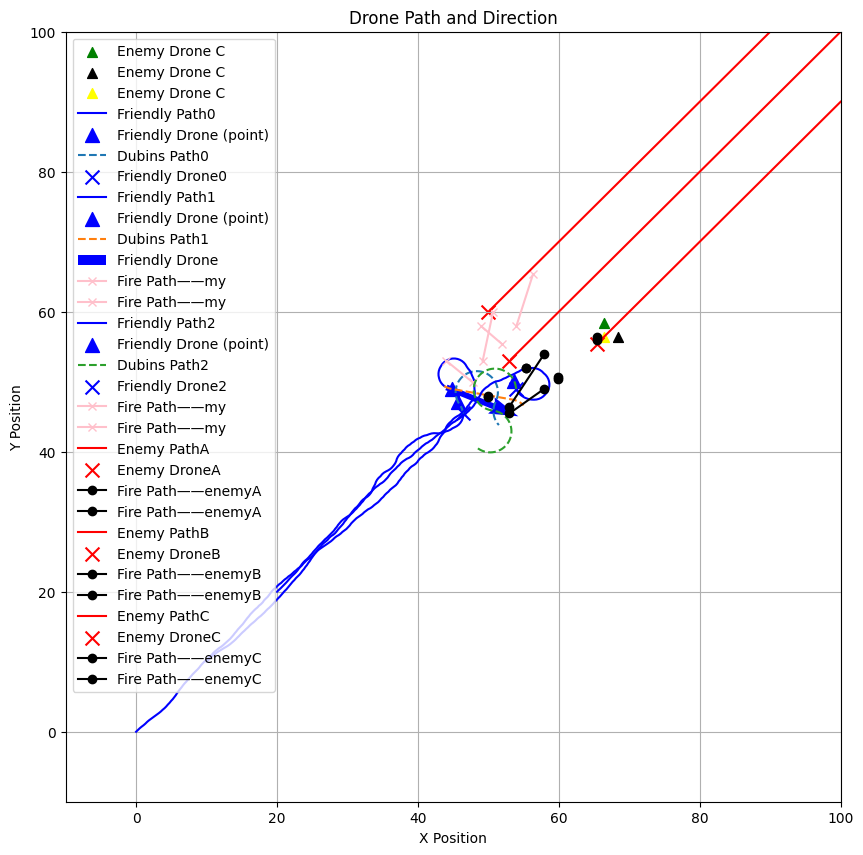

In [11]:
env = AirFightEnv()
state = env.reset()
discrete_data, continuous_data = separate_data(state)
normal_data=Normalization()
for n in range(1000):

    processed_state,normal_data.mean,normal_data.variance=process_continue_data(state,normal_data.mean,normal_data.variance,n) #没有batch_size
    # print(np.array(processed_state).shape)
    new_oij_state=Net2data(processed_state,state)
    # print(torch.tensor(new_oij_state,dtype=torch.float32))
    action, old_log_probs,value = agent.get_action(processed_state,new_oij_state)

    # # action_list = [[tgt.item(), tac.item()] for tgt, tac in zip(target_actions, tactic_actions)]
    result_action = [[num + 1 for num in sublist] for sublist in action]

    next_state, reward, done, info = env.step(result_action)
    print(action)
    # print(target_actions+1,'----\n',tactic_actions+1)

    
    env.render(mode='human')  # 显示图像
    if done:
        break









In [69]:
###出现了需要float32 64.。。。。 输出错了状态state->new state
for t in range(1,100):
    s=21.64*math.log(t) +7.88
    print(t,s)

1 7.88
2 22.879704987317215
3 31.653969926777894
4 37.879409974634434
5 42.708236425073935
6 46.65367491409511
7 49.989495625556984
8 52.87911496195165
9 55.42793985355579
10 57.70794141239116
11 59.77045370335674
12 61.65337990141233
13 63.38550409546766
14 64.98920061287419
15 66.48220635185183
16 67.87881994926886
17 69.19073676537651
18 70.427644840873
19 71.59765950916177
20 72.70764639970835
21 73.76346555233486
22 74.77015869067395
23 75.73209483270679
24 76.65308488872954
25 77.53647285014786
26 78.38520908278487
27 79.20190978033368
28 79.9889056001914
29 80.7482817609073
30 81.48191133916905
31 82.19148310505857
32 82.87852493658608
33 83.54442363013463
34 84.19044175269373
35 84.81773205063091
36 85.42734982819022
37 86.02026362962101
38 86.59736449647899
39 87.15947402224555
40 87.70735138702558
41 88.24169952348122
42 88.7631705396521
43 89.27237050360868
44 89.76986367799117
45 90.25617627862971
46 90.73179982002401
47 91.19719410100566
48 91.65278987604677
49 92.09899125